## Human iris center detection 


### 3.1. Uploading Data

In [ ]:
%%capture
!wget https://www2.unavarra.es/gesadj/GI4E/gi4e_database.zip
!unzip gi4e_database.zip

### 3.2. Libraries Installation


In [ ]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import glob
import numpy as np
import pandas as pd

### 3.3. Data Preprocessing

#### 3.3.1. Read Data and Data exploration
- Convert images to gray and store them in a list and visualize one image



Number of images in dataset : 1236



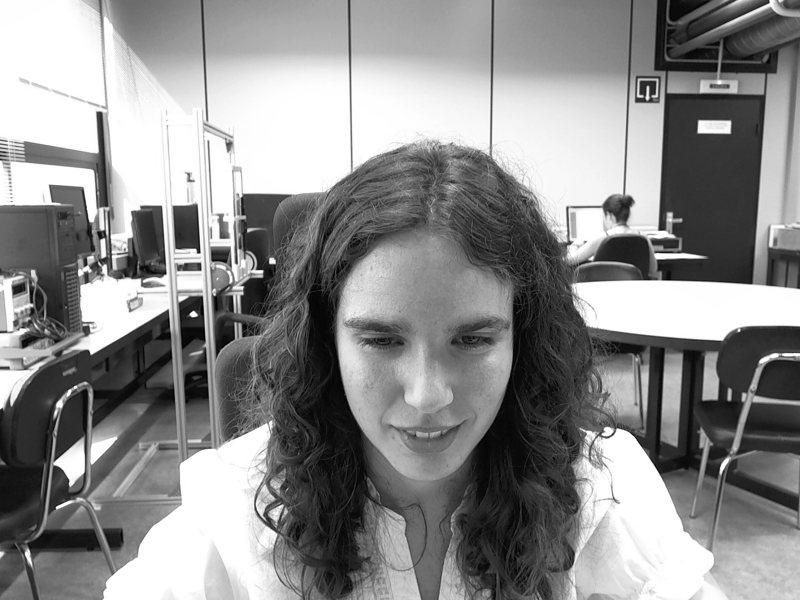

In [ ]:
images = [cv2.imread(img,0) for img in sorted(glob.glob("/content/images/*.png"))]
print(f'Number of images in dataset : {len(images)}\n')
cv2_imshow(images[0]) # please note that cv2_imshow work only on colab, it might give an error on jupyter 

# plt.axis("off")
# plt.imshow(images[0], cmap='gray')
# plt.show()

#### 3.3.2. Read annotation for images
- Read images labels with pandas


In [ ]:
data = pd.read_csv('/content/labels/image_labels.txt',sep = "\t",header=None)
data = data.loc[:, 1:12]
data

,1,2,3,4,5,6,7,8,9,10,11,12
0,490.63,338.28,471.22,338.41,452.86,341.93,401.95,342.45,383.33,339.84,362.63,338.41
1,493.49,332.94,479.30,333.33,455.86,340.23,404.69,340.11,391.02,334.50,364.58,335.81
2,495.05,333.86,477.47,332.94,458.07,339.32,407.29,339.71,389.45,333.33,368.88,334.89
3,493.62,334.25,472.66,332.42,456.38,338.80,405.08,340.11,385.03,334.11,367.84,336.46
4,495.83,333.33,470.57,331.64,457.68,338.02,406.77,339.45,382.81,333.33,369.92,334.38
...,...,...,...,...,...,...,...,...,...,...,...,...
1231,503.25,152.61,491.80,151.69,477.21,153.00,427.47,157.29,414.19,158.20,401.56,161.85
1232,504.04,154.04,493.88,153.52,478.25,153.91,428.52,158.20,416.67,160.16,401.43,163.15
1233,504.82,154.56,493.62,153.00,478.64,154.17,428.52,158.59,416.67,160.68,402.34,163.54
1234,505.47,155.60,490.89,154.82,478.78,154.95,428.25,159.38,414.19,161.33,402.34,164.06


In [ ]:
x1 = data[1].to_numpy().astype(int)
y1 = data[2].to_numpy().astype(int)
x2 = data[3].to_numpy().astype(int)
y2 = data[4].to_numpy().astype(int)
x3 = data[5].to_numpy().astype(int)
y3 = data[6].to_numpy().astype(int)
x4 = data[7].to_numpy().astype(int)
y4 = data[8].to_numpy().astype(int)
x5 = data[9].to_numpy().astype(int)
y5 = data[10].to_numpy().astype(int)
x6 = data[11].to_numpy().astype(int)
y6 = data[12].to_numpy().astype(int)

#### 3.3.3. Visualize one image, draw eye corners and iris center


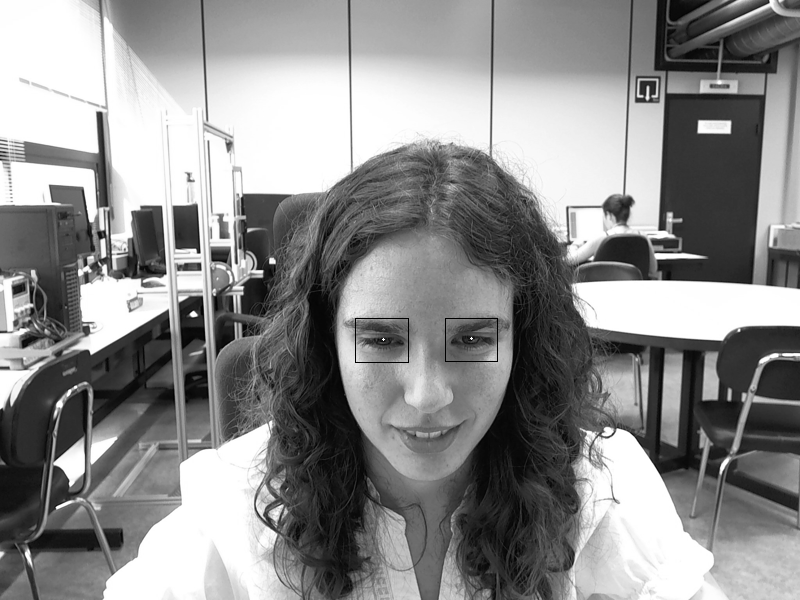

(600, 800)


In [ ]:
Upper_Left = (x1[0]+7, y1[0]-20)
Bottom_Right = (x3[0]-7, y3[0]+20)
L_center_coordinates = (x2[0], y2[0]) 
Upper_Right = (x4[0]+7, y4[0]+20)
Bottom_Left = (x6[0]-7, y6[0]-20)
R_center_coordinates = (x5[0], y5[0]) 
new_image = images[0].copy()
new_image = cv2.rectangle(new_image, Upper_Left, Bottom_Right, color=(0,255,0), thickness=1) 
new_image = cv2.circle(new_image, L_center_coordinates, radius=0, color=(255,0,0), thickness=2) 
new_image = cv2.rectangle(new_image, Upper_Right, Bottom_Left, color=(0,255,0), thickness=1) 
new_image = cv2.circle(new_image, R_center_coordinates, radius=0, color=(255,0,0), thickness=2)
cv2_imshow(new_image)
print(new_image.shape)

#### 3.3.4. Crop eye region for all images and visualize a cropped image



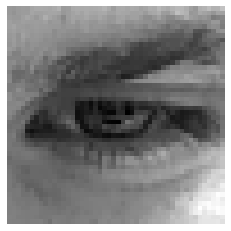

(48, 48)


In [ ]:
crop_images = []
x_iris = np.zeros(x2.shape,dtype=int)
y_iris = np.zeros(y2.shape,dtype=int)
for j in range(len(images)):
  mx = int((x1[j] + x3[j])/2) 
  my = int((y3[j] + y1[j])/2)

  Xc = mx-24
  Yc = my-24

  x_iris[j] = x2[j]-Xc
  y_iris[j] = y2[j]-Yc

  crop_images.append(images[j][Yc:Yc+48 , Xc:Xc+48])

# cv2_imshow(crop_images[0])
plt.axis("off")
plt.imshow(crop_images[0], cmap='gray')
plt.show()
print(crop_images[0].shape)

#### 3.3.5. Normalize images (divide by 255)

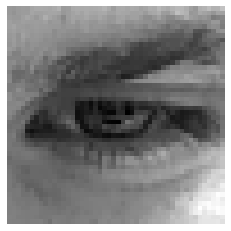

In [ ]:
crop_images = np.array(crop_images)
N_images = crop_images/255.0

plt.axis("off")
plt.imshow(N_images[0], cmap='gray')
plt.show()

#### 3.3.6. Creating final dataset X , Y

- It is stated in the paper that applying Dilation and Gaussian filtering to the target increases the accuracy, that is why Dilation and Gaussian filtering are applied below.


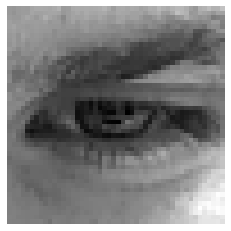

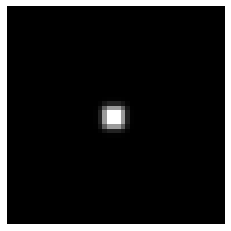

(48, 48)


In [ ]:
from scipy.ndimage import gaussian_filter

X = N_images
Y = np.zeros(X.shape)

#Set kernel for dilation 
kernel = np.ones((3,3),np.uint8)

for k in range(len(X)):
  img = np.zeros((48,48))
  img[x_iris[k],y_iris[k]] = 1
  
  img = gaussian_filter(img, 1)
  img = cv2.dilate(img,kernel,iterations = 1)
  
  Y[k] = img
 
plt.axis("off")
plt.imshow(X[0], cmap='gray')
plt.show()

plt.axis("off")
plt.imshow(Y[0], cmap='gray')
plt.show()
print(Y[0].shape)

#### 3.3.7. Data split into train and test
- Testset is assumed as 20% of the whole dataset.
- X, Y are expanded by 1 dimension to match the dimensions of CNN model.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2) 

X_train = np.expand_dims(X_train, 1)
Y_train = np.expand_dims(Y_train, 1)
X_test = np.expand_dims(X_test, 1)
Y_test = np.expand_dims(Y_test, 1)

print(f'X_test size {X_test.shape} , Y_test size {Y_test.shape}')

X_test size (248, 1, 48, 48) , Y_test size (248, 1, 48, 48)


### 3.4. Building the model


#### 3.4.1. Import Necessary Libraries

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

#### 3.4.2. Autoencoder
In this section Autoencoder is applied which contains the following:

- Base network
- Auxiliary Network
- Skip Connection is applied as proposed in the attached paper.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        #Encoder layers:
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)  
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1) 
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        #Base Network:
        self.conv1_T = nn.ConvTranspose2d(256, 64, 4, stride=4)
        self.conv4 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 1, 3, padding=1)

        #Auxiliary Network:
        self.conv2_T = nn.ConvTranspose2d(256, 128, 4, stride=2,padding=1)
        self.conv3_T = nn.ConvTranspose2d(128, 64, 4, stride=2,padding=1)


    def forward(self, x):
        #Encoder:
        x_skip = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x_skip))
        x = self.pool1(x) 
        x = F.relu(self.conv3(x))
        x = self.pool2(x) 
    
        #Base Network:
        y = F.relu(self.conv1_T(x))
        y = torch.cat((x_skip,y),1)
        y = F.relu(self.conv4(y))
        y = torch.tanh(self.conv5(y))

        #Auxiliary Network:
        ax = F.relu(self.conv2_T(x))
        ax = F.relu(self.conv3_T(ax))
        ax = torch.tanh(self.conv5(ax))
     
        return y,ax

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Autoencoder().to(device)

#### 3.4.3. Functions 

In this section the following functions are created: 
- Train Function.
- Test Function.
- TesnorToImage which converts the tensor into image.


In [ ]:
def train(model, device, train_loader, optimizer, epoch,loss_func):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y,ax = model(data)
        loss1 = loss_func(y, target)
        loss2 = loss_func(ax, data)
        total_loss = loss1+loss2
        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item()
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, epoch, total_loss.item()))
       

def test(model, device, test_loader,loss_func):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
         for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            view_data = data
            y,ax = model(data)
            test_loss += loss_func(y, target).item()   
           
         test_loss /= len(test_loader.dataset)
         print('\nTest set: Average loss: {:.4f}'.format(test_loss)) 

    return y,view_data

def TesnorToImage(tensor):
    tensor_ = tensor.cpu().numpy()
    tensor_ = tensor_.reshape([48, 48])
    return tensor_

#### 3.4.4. CNN Model
In this section: 
- X, Y are transformed to torch tensors.
- Dataloaders are built.
- Model training and testing is performed. 
- Visualization of some images.

After running the model with different optimizers : [sgd, adam, adamax, rmsprop], loss functions : [mse,mae] , and activations : [tanh, relu, sigmoid] , the best combination is found using the following:
- Optimizer : Adam
- Learning rate = 0.001
- Number of epochs = 100 , could be increased for better accuracy.
- Loss function : MSE
- Activation function : Tanh




epoch [2/1], loss:0.2181
epoch [2/1], loss:0.1903
epoch [2/1], loss:0.1211
epoch [2/1], loss:0.0493
epoch [2/1], loss:0.0629
epoch [2/1], loss:0.0339
epoch [2/1], loss:0.0444
epoch [2/1], loss:0.0349
epoch [2/1], loss:0.0221
epoch [2/1], loss:0.0295
epoch [2/1], loss:0.0224
epoch [2/1], loss:0.0131
epoch [2/1], loss:0.0163
epoch [2/1], loss:0.0181
epoch [2/1], loss:0.0129
epoch [2/1], loss:0.0104

Test set: Average loss: 0.0000
1
epoch [3/2], loss:0.0117
epoch [3/2], loss:0.0134
epoch [3/2], loss:0.0103
epoch [3/2], loss:0.0106
epoch [3/2], loss:0.0116
epoch [3/2], loss:0.0090
epoch [3/2], loss:0.0070
epoch [3/2], loss:0.0094
epoch [3/2], loss:0.0071
epoch [3/2], loss:0.0063
epoch [3/2], loss:0.0056
epoch [3/2], loss:0.0068
epoch [3/2], loss:0.0057
epoch [3/2], loss:0.0050
epoch [3/2], loss:0.0059
epoch [3/2], loss:0.0054

Test set: Average loss: 0.0000
2
epoch [4/3], loss:0.0047
epoch [4/3], loss:0.0052
epoch [4/3], loss:0.0053
epoch [4/3], loss:0.0050
epoch [4/3], loss:0.0042
epoch [

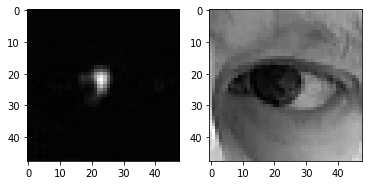

In [ ]:
tensor_x_tr = torch.Tensor(X_train) 
tensor_y_tr = torch.Tensor(Y_train)
tensor_x_test = torch.Tensor(X_test) 
tensor_y_test = torch.Tensor(Y_test)

epochs = 100
learning_rate = 0.001
batchSize = 64
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

train_loader = DataLoader(TensorDataset(tensor_x_tr,tensor_y_tr),batch_size=batchSize,shuffle=True)
test_loader = DataLoader(TensorDataset(tensor_x_test,tensor_y_test),batch_size=batchSize, shuffle=False)

for epoch in range(1, epochs + 1):
  train(model, device, train_loader, optimizer, epoch, criterion)
  iris_pred , iris_img = test(model, device, test_loader, criterion)
  print(epoch)

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(TesnorToImage(iris_pred[0]),cmap='gray')
fig.add_subplot(1,2,2)
plt.imshow(TesnorToImage(iris_img[0]),cmap='gray')
plt.show(block=True)

### 3.5. Prediction 
10 tests images are selected for prediction and predicted centers are drawn for visualization. 


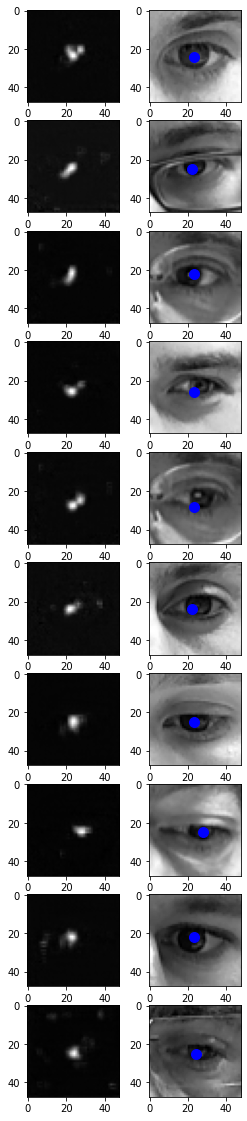

In [ ]:
fig = plt.figure(figsize=[4,20])
for i in range(0,10):
  y_iris_pred = TesnorToImage(iris_pred[i+3])
  view_img = TesnorToImage(iris_img[i+3])

  (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(y_iris_pred)
  #print(maxLoc)

  fig.add_subplot(10,2,i*2+1)
  plt.imshow(y_iris_pred,cmap='gray')

  fig.add_subplot(10,2,i*2+2)
  plt.imshow(view_img,cmap='gray')
  plt.plot(maxLoc[0], maxLoc[1], 'b.', markersize=20)